# 2 Exercise

### 1. What is the cache capacity of the computer you used (please write the workstation name)?

In [26]:
memo_num_accesses = {}


def num_accesses(array_size):
    """Array size in KiB"""

    key = array_size
    if key in memo_num_accesses:
        return memo_num_accesses[key]

    array_size = array_size << 10

    N_REPETITIONS = 100

    STRIDE_MAX = 2

    counter = 0
    stride = 1

    for stride in range(1, STRIDE_MAX, stride):

        limit = array_size - stride + 1

        for repeat in range(0, N_REPETITIONS * stride):
            counter += (limit - 0) / stride

    counter = int(counter)
    memo_num_accesses[key] = counter

    return counter

In [27]:
import pandas as pd

In [28]:
df = pd.DataFrame()
for i in range(10):
    df = pd.concat((df, pd.read_csv(f"./data/spark{i:0>2}.tsv", delimiter = "\t")))

df = df.reset_index()

In [29]:
df_avg = df.groupby(["size"], as_index = False).mean().drop("index", axis = 1)

In [30]:
df_avg["accesses"] = df_avg["size"].apply(lambda x: num_accesses(x >> 10))
df_avg["mean_access_time"] = df_avg["elapsed(s)"] / df_avg["accesses"]
df_avg["mean_access_time (ns)"] = df_avg["mean_access_time"].apply(
    lambda x: x * 10**9
)
df_avg["size (KiB)"] = df_avg["size"].apply(lambda x: x >> 10)

In [31]:
df_avg.sort_values("size")[
    ["size (KiB)", "elapsed(s)", "accesses", "mean_access_time (ns)"]
]

,size (KiB),elapsed(s),accesses,mean_access_time (ns)
0,4,0.001067,409600,2.604635
1,8,0.001777,819200,2.168673
2,16,0.003610,1638400,2.203491
3,32,0.007116,3276800,2.171777
4,64,0.016130,6553600,2.461169
5,128,0.037211,13107200,2.838962
6,256,0.086599,26214400,3.303504
7,512,0.190887,52428800,3.640883
8,1024,0.407381,104857600,3.885087
9,2048,0.862403,209715200,4.112260


Upon analyzing the table above, which presents data collected from running the Spark program on the lab6p8 computer, we can determine that the cache capacity is 32KiB. This conclusion arises from the observation that the mean access time remains relatively constant for array sizes up to 32KiB (inclusive). However, once we reach 64KiB, the mean access time increases, suggesting a rise in the miss rate due to the L1 cache being filled. Consequently, it becomes clear that array sizes exceeding 32KiB no longer fit within the cache, resulting in longer access times.

### 2. What is the cache capacity?

Figure 1 shows two groups of array sizes based on cache access times: one around 375 ns and the other around 500 ns. The first group likely includes arrays of size less than or equal to the cache capacity, indicating that these arrays can fully reside in the cache, resulting in lower access times. In contrast, the second group experiences higher execution times due to increased miss penalties as the arrays exceed cache capacity.

The spike in reading and writing times beyond 64 KB confirms that this is the cache size limit, with the increase between 64 KB and 128 KB reflecting higher capacity misses. Thus, we conclude that the cache capacity corresponds to the maximum array size in the lower access time group: 64 KiB.

### 3. What is the size of each cache block?

The size of a cache block can be determined by identifying the first stride where the access time stabilizes for the array sizes that do not fully fit in the cache (greater than 64 KB). We observe that the access time remains consistent for strides of 16 Bytes or larger, indicating that each accessed element corresponds to distinct cache blocks, resulting in a near 100% miss rate. Therefore, we can conclude that each cache block has a size of 16 Bytes.

### 4. What is the L1 cache miss penalty time?

To calculate the L1 cache miss penalty time, we compare the total execution times for different array sizes and access patterns. 
For array sizes that are smaller than the cache size, the miss rate is nearly 0%, resulting in an access time of approximately 375 ns. 
For larger arrays with a stride of 16 Bytes or greater, the access time increases to around 975 ns due to a nearly 100% miss rate.

Therefore, the miss penalty can be determined by subtracting the lower access time from the higher one: 975 ns - 375 ns = 600 ns. 

# 3  Procedure

#### 3.1.1 Modeling the L1 Data Cache

a) What are the processor events that will be analyzed during its execution? Explain their meaning.

During the program's execution, the analyzed events will be L1 cache misses, which occur when data is not found in the L1 cache and access to the next memory level (L2 cache or main memory) is required. The cm1.c program tracks the PAPI_L1_DCM event, indicating "L1 Data Cache Misses". This analysis aims to quantify how often we attempt to retrieve data absent from the L1 cache throughout the program's runtime.

b) Plot the variation of the average number of misses (Avg Misses) with the stride size, for each considered dimension of the L1 data cache (8kB, 16kB, 32kB and 64kB).

In [32]:
from math import log2
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
def strip_labels(val):
    value = val.split("=")[1]
    return float(value) if "." in value else int(value)

df = pd.DataFrame()

for i in range(10):
    df = pd.concat(
        (
            df,
            pd.read_csv(
                f"./data/cm1_l1_{i:0>2}.tsv",
                delimiter = "\t",
                names = ["cache_size", "stride", "avg_misses", "avg_time"],
                converters = {
                    "cache_size": strip_labels,
                    "stride": strip_labels,
                    "avg_misses": strip_labels,
                    "avg_time": strip_labels,
                },
            ),
        )
    )

df = df.reset_index()

df_avg = (
    df.groupby(["cache_size", "stride"], as_index  =False).median().drop("index", axis = 1)
)

print(df_avg)

df_avg["cache_size"] = df_avg["cache_size"] // 1024

    cache_size  stride  avg_misses  avg_time
0         8192       1    0.000228  0.002718
1         8192       2    0.000155  0.002822
2         8192       4    0.000077  0.002825
3         8192       8    0.000059  0.002779
4         8192      16    0.000065  0.002825
5         8192      32    0.000058  0.002837
6         8192      64    0.000056  0.002603
7         8192     128    0.000031  0.002182
8         8192     256    0.000016  0.002008
9         8192     512    0.000013  0.001989
10        8192    1024    0.000007  0.001951
11        8192    2048    0.000010  0.002037
12        8192    4096    0.000009  0.002079
13       16384       1    0.000242  0.002258
14       16384       2    0.000186  0.002252
15       16384       4    0.000189  0.002246
16       16384       8    0.000181  0.002180
17       16384      16    0.000191  0.002246
18       16384      32    0.000189  0.002247
19       16384      64    0.000171  0.002206
20       16384     128    0.000083  0.002175
21       1

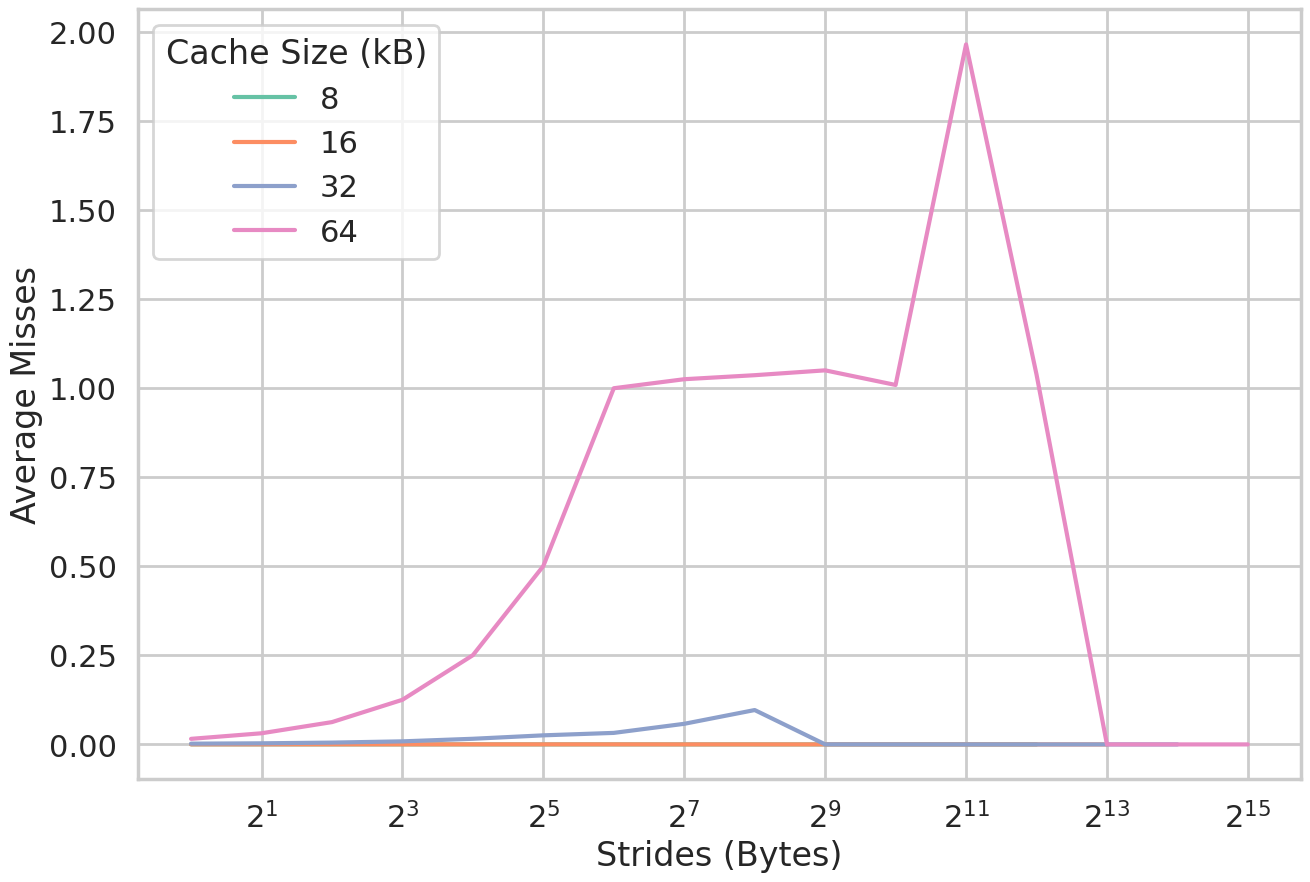

In [34]:
plt.figure(figsize = (15, 10))
sns.set_theme(context = "poster", style = "whitegrid")

g_results = sns.lineplot(
    data = df_avg, x = "stride", y = "avg_misses", hue = "cache_size" , palette = "Set2"
)
g_results.set_xscale("log", base = 2)
g_results.set_xlabel("Strides (Bytes)")
g_results.set_ylabel("Average Misses")
g_results.get_legend().set_title("Cache Size (kB)")

plt.show()


c) By analyzing the obtained results:

• Determine the size of the L1 data cache. Justify your answer.

Determining the L1 cache size involves analyzing the plot of average misses versus array size. The blue line at 32kB shows that average misses remain at zero, indicating the cache can efficiently handle this size. A slight increase in misses at certain strides can be attributed to other data occupying the cache.

Above 32kB, average miss rates spike significantly, suggesting that the array previously fit in the cache but exceeds its capacity at 64kB, leading to increased misses. Therefore, we can conclude that the L1 cache size is 32kB.

• Determine the block size adopted in this cache. Justify your answer.

The cache block size is  64 Bytes based on the analysis of the miss rate as strides vary. When strides are less than 64 Bytes = 2^6, the miss rate continues to increase, indicating that some accesses hit the cache and reside within the same block as previous accesses. Once the stride reaches 64 Bytes, the miss rate stabilizes at 1, suggesting that we are consistently loading new blocks into the cache, as the data being accessed is guaranteed not to be in the cache anymore. This stabilization occurs because a stride of 64 Bytes means that we skip over the entire block size, leading to sequential accesses to different blocks. 

• Characterize the associativity set size adopted in this cache. Justify your answer.

Determining the associativity set size involves examining how the miss rate behaves as we adjust the stride. Focusing on the largest cache size (indicated by the pink line at 64kB), we observe that when using a stride of 2^15, only two distinct blocks of data are accessed, leading to a near-zero miss rate, provided the cache has at least 2-way associativity.
Continuing with this analysis for lower strides, we see that the miss rate remains close to zero at 2^14 and 2^13. This observation implies that the cache is at least 4-way or 8-way associative. However, when we test a stride of 2^12, the miss rate increases significantly, indicating that we have surpassed the associativity capacity of the cache.
This leads to the conclusion that the associativity set size is 8.

#### 3.1.2 Modeling the L2 Cache

a) Describe and justify the changes introduced in this program.

b) Plot the variation of the average number of misses (Avg Misses) with the stride size, for each considered dimension of the L2 cache.

In [35]:
def strip_labels(val):
    value = val.split("=")[1]
    return float(value) if "." in value else int(value)

df = pd.DataFrame()

for i in range(10):
    df = pd.concat(
        (
            df,
            pd.read_csv(
                f"./data/cm1_l2_{i:0>2}.tsv",
                delimiter = "\t",
                names = ["cache_size", "stride", "avg_misses", "avg_time"],
                converters = {
                    "cache_size": strip_labels,
                    "stride": strip_labels,
                    "avg_misses": strip_labels,
                    "avg_time": strip_labels,
                },
            ),
        )
    )

df = df.reset_index()

df_avg = (
    df.groupby(["cache_size", "stride"], as_index = False).median().drop("index", axis = 1)
)

print(df_avg)

df_avg["cache_size"] = df_avg["cache_size"] // 1024

     cache_size   stride  avg_misses  avg_time
0          8192        1    0.000406  0.002681
1          8192        2    0.000151  0.002803
2          8192        4    0.000027  0.002795
3          8192        8    0.000030  0.002727
4          8192       16    0.000020  0.002788
..          ...      ...         ...       ...
148     2097152    65536    0.193214  0.008452
149     2097152   131072    0.000017  0.005635
150     2097152   262144    0.000002  0.002338
151     2097152   524288    0.000001  0.002171
152     2097152  1048576    0.000001  0.002080

[153 rows x 4 columns]


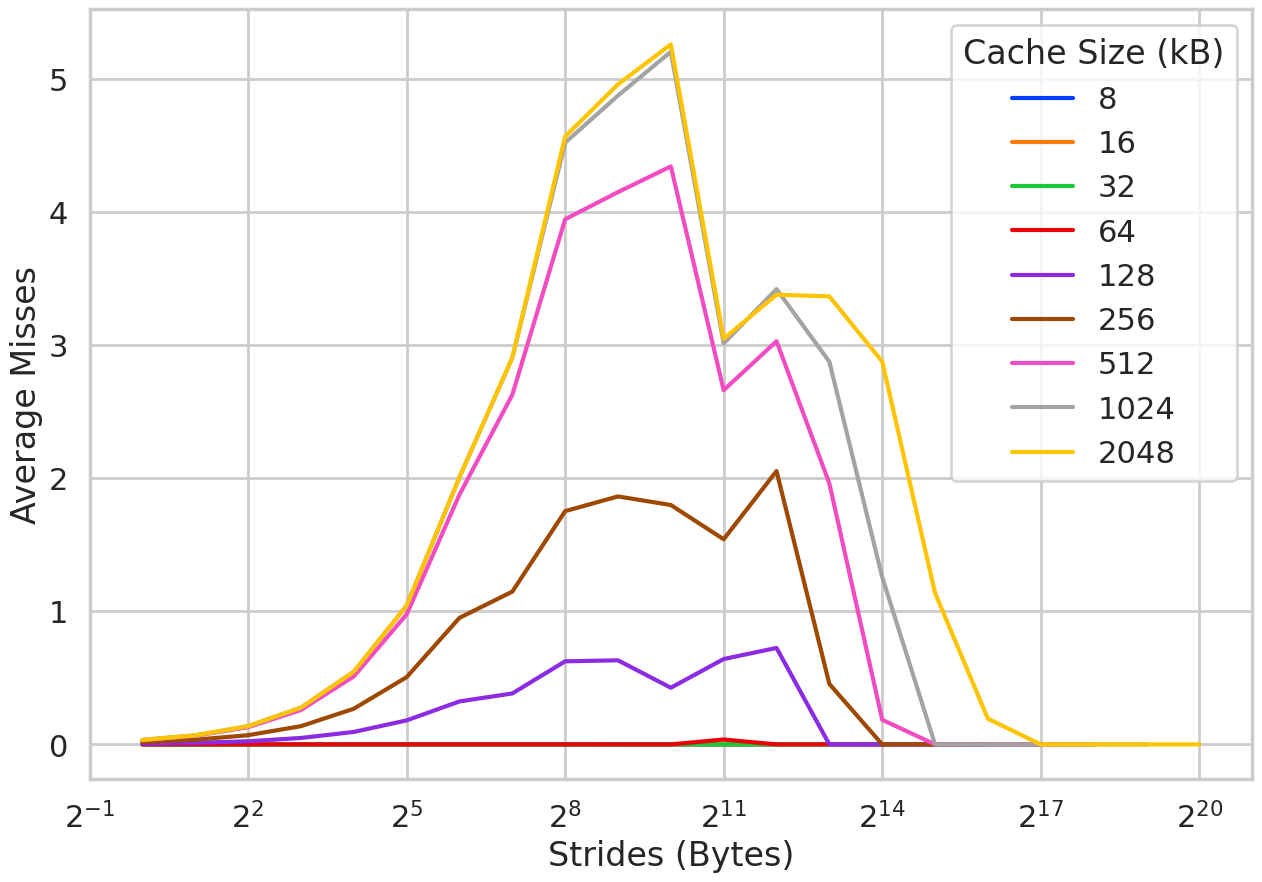

In [36]:
plt.figure(figsize = (15, 10))
sns.set_theme(context = "poster", style = "whitegrid")

g_results = sns.lineplot(
    data = df_avg, x = "stride", y = "avg_misses", hue = "cache_size" , palette = "bright"
)
g_results.set_xscale("log", base = 2)
g_results.set_xlabel("Strides (Bytes)")
g_results.set_ylabel("Average Misses")
g_results.get_legend().set_title("Cache Size (kB)")

plt.show()

c) By analyzing the obtained results:

• Determine the size of the L2 cache. Justify your answer.

• Determine the block size adopted in this cache. Justify your answer.

• Characterize the associativity set size adopted in this cache. Justify your answer.

### 3.2 Profiling and Optimizing Data Cache Accesses

#### 3.2.1 Straightforward implementation

a) What is the total amount of memory that is required to accommodate each of these matrices?

b) Fill the table with the obtained data.

c) Evaluate the resulting L1 data cache Hit-Rate.

### 3.2.2 First Optimization: Matrix transpose before multiplication [2]

a) Fill the table with the obtained data.

b) Evaluate the resulting L1 data cache Hit-Rate.

c) Fill the table with the obtained data.

Comment on the obtained results when including the matrix transposition in the execution time.

d) Compare the obtained results with those that were obtained for the straightforward implementation,
by calculating the difference of the resulting hit-rates (∆HitRate) and the obtained speedups.

### 3.2.3 Second Optimization: Blocked (tiled) matrix multiply [2]

a) How many matrix elements can be accommodated in each cache line?

b) Fill the table with the obtained data.

c) Evaluate the resulting L1 data cache Hit-Rate.

d) Compare the obtained results with those that were obtained for the straightforward implementation,
by calculating the difference of the resulting hit-rates (∆HitRate) and the obtained speedup.

e) Compare the obtained results with those that were obtained for the matrix transpose implementation by calculating the difference of the resulting hit-rates (∆HitRate) and the obtained speedup.If the obtained speedup is positive, but the difference of the resulting hit-rates is negative, how
do you explain the performance improvement? (Hint: study the hit-rates of the L2 cache for both
implementations;)

### 3.2.3 Comparing results against the CPU specifications

Now that you have characterized the cache on your lab computer, you are going to compare it against the
manufacturer’s specification. For this you can check the device’s datasheet, or make use of the command
lscpu. Comment the results.